Preprocessing the Data

In [2]:
import csv
import os

def to_lower_case(s):
    """ Convert a string to lowercase. E.g., 'BaNaNa' becomes 'banana'.
    """
    return s.lower()



def strip_non_alpha(s):
    """ Remove non-alphabetic characters from the beginning and end of a string.

    E.g. ',1what?!"' should become 'what'. Non-alphabetic characters in the middle
    of the string should not be removed. E.g. "haven't" should remain unaltered."""

    s = s.strip()
    if len(s)==0:
        return s
    if not s[0].isalpha():
        return strip_non_alpha(s[1:])
    elif not s[-1].isalpha():
        return strip_non_alpha(s[:-1])
    else:
        return s

def clean(s):
    """ Create a "clean" version of a string
    """
    return to_lower_case(strip_non_alpha(s))


# Directory of text files to be processed

directory = 'labeled_articles'



# Learn the vocabulary of words in the corpus
# as well as the categories of labels used per text

categories = {}
vocabulary = {}


num_files = 0
for filename in [x for x in os.listdir(directory) if ".txt" in x]:
    num_files +=1
    print("Processing",filename,"...",end="")
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f,'r') as  fp:
            for line in fp:
                line = line.strip()
                if "###" in line:
                    continue
                if "--" in line:
                    label, words = line.split("--")
                    words = [clean(word) for word in words.split()]
                else:
                    words = line.split()
                    label = words[0]
                    words = [clean(word) for word in words[1:]]

                if label not in categories:
                    index = len(categories)
                    categories[label] = index

                for word in words:
                    if word not in vocabulary:
                        index = len(vocabulary)
                        vocabulary[word] = index
    print(" done")

n_words = len(vocabulary)
n_cats = len(categories)

print("Read %d files containing %d words and %d categories" % (num_files,len(vocabulary),len(categories)))

print(categories)


# Convert sentences into a "bag of words" representation.
# For example, "to be or not to be" is represented as
# a vector with length equal to the vocabulary size,
# with the value 2 at the indices corresponding to "to" and "be",
# value 1 at the indices corresponding to "or" and "not"
# and zero everywhere else.


X = []
y = []

for filename in [x for x in os.listdir(directory) if ".txt" in x]:
    print("Converting",filename,"...",end="")
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f,'r') as  fp:
            for line in fp:
                line = line.strip()
                if "###" in line:
                    continue
                if "--" in line:
                    label, words = line.split("--")
                    words = [clean(word) for word in words.split()]
                else:
                    words = line.split()
                    label = words[0]
                    words = [clean(word) for word in words[1:]]

                y.append(categories[label])

                features = n_words * [0]

                bag = {}
                for word in words:
                    if word not in bag:
                        bag[word] = 1
                    else:
                        bag[word] += 1

                for word in bag:
                    features[vocabulary[word]] = bag[word]

                X.append(features)
    print(" done")

# Save X and y to files

with open('X_snts.csv', 'w') as csvfile:
    fw = csv.writer(csvfile, delimiter=',')
    for features in X:
        fw.writerow(features)

with open('y_snts.csv', 'w') as csvfile:
    fw = csv.writer(csvfile, delimiter=',')
    for label in y:
        fw.writerow([label])

Processing arxiv_annotate10_7_1.txt ... done
Processing arxiv_annotate10_7_2.txt ... done
Processing arxiv_annotate10_7_3.txt ... done
Processing arxiv_annotate1_13_1.txt ... done
Processing arxiv_annotate1_13_2.txt ... done
Processing arxiv_annotate1_13_3.txt ... done
Processing arxiv_annotate2_66_1.txt ... done
Processing arxiv_annotate2_66_2.txt ... done
Processing arxiv_annotate2_66_3.txt ... done
Processing arxiv_annotate3_80_1.txt ... done
Processing arxiv_annotate3_80_2.txt ... done
Processing arxiv_annotate3_80_3.txt ... done
Processing arxiv_annotate4_168_1.txt ... done
Processing arxiv_annotate4_168_2.txt ... done
Processing arxiv_annotate4_168_3.txt ... done
Processing arxiv_annotate5_240_1.txt ... done
Processing arxiv_annotate5_240_2.txt ... done
Processing arxiv_annotate5_240_3.txt ... done
Processing arxiv_annotate6_52_1.txt ... done
Processing arxiv_annotate6_52_2.txt ... done
Processing arxiv_annotate6_52_3.txt ... done
Processing arxiv_annotate7_268_1.txt ... done
Pro

Code for the task

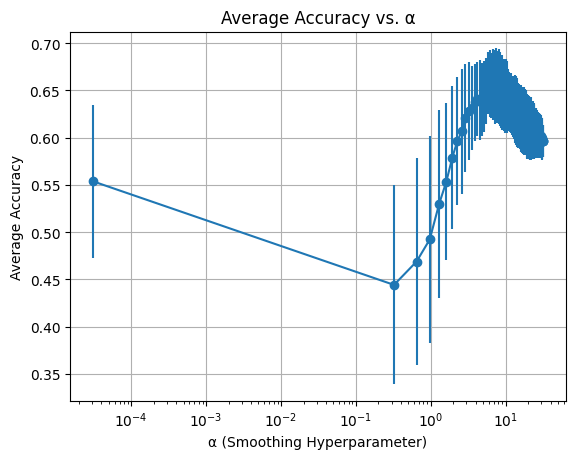

Optimal α: 5.818206787109375
Top 5 words for Class 0 at optimal α: ['the', 'of', 'to', 'citation', 'and']
Top 5 words for Class 1 at optimal α: ['the', 'of', 'a', 'to', 'we']


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

# Load your preprocessed data
X = pd.read_csv('X_snts.csv', header=None)
y = pd.read_csv('y_snts.csv', header=None).values.ravel()

# Define the range of α values to explore
alp_values = np.linspace(2**-15, 2**5, 100)

# Initialize lists to store average accuracy and standard deviation
avg_accu = []
std_accu = []

# Initialize dictionary to store the top 5 words for each class
top_words = {}

# Perform 10-fold cross-validation for each value of α
for alpha in alp_values:
    # Create Multinomial Naive Bayes classifier with current α value
    classf = MultinomialNB(alpha=alpha)

    # Perform cross-validation and get accuracy scores
    accu_scores = cross_val_score(classf, X, y, cv=10)

    # Calculate average accuracy and standard deviation
    average_acc = np.mean(accu_scores)
    standard_acc = np.std(accu_scores)

    # Store average accuracy and standard deviation
    avg_accu.append(average_acc)
    std_accu.append(standard_acc)

    # Fit the classifier on the entire dataset
    classf.fit(X, y)

    # Get the top 5 words for each class
    top_words[str(alpha)] = {
        'Class 0': [word for _, word in sorted(zip(classf.feature_log_prob_[0], vocabulary.keys()), reverse=True)[:5]],
        'Class 1': [word for _, word in sorted(zip(classf.feature_log_prob_[1], vocabulary.keys()), reverse=True)[:5]]
    }

# Plot average accuracy as a function of α
plt.errorbar(alp_values, avg_accu, yerr=std_accu, fmt='-o')
plt.xscale('log')
plt.xlabel('α (Smoothing Hyperparameter)')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy vs. α')
plt.grid(True)
plt.show()

# Find the α value that maximizes the average accuracy
opt_alpha = alp_values[np.argmax(avg_accu)]
print("Optimal α:", opt_alpha)

# Report the top 5 words for each class corresponding to the optimal α
print("Top 5 words for Class 0 at optimal α:", top_words[str(opt_alpha)]['Class 0'])
print("Top 5 words for Class 1 at optimal α:", top_words[str(opt_alpha)]['Class 1'])
